# A Study of Kurtosis and Skewness of Import Value Distributions

In [1]:
import pandas as pd

df = pd.read_csv('C:/Users/2093/Documents/R/testapp/data/comp_aggregate_6.csv',
                 encoding='hkscs', dtype={'product': str})
df = df[['country', 'product', 'desc2', 'desc4', 'desc6', 'n_partner', 'kurtos', 'skew']].set_index(
    ['country', 'product', 'desc2', 'desc4', 'desc6'])

In [2]:
print(df.isnull().assign(count=1).groupby(['n_partner', 'kurtos', 'skew']).count())

                         count
n_partner kurtos skew         
False     False  False  530269
                 True    72904
True      True   True   153562


Sources of NaN's:
1. When there is only one source of imports or all sources import exactly the same amount, standard deviation is zero, and so skewness is undefined.
2. If import value 2015 of a product is zero, then ```n_partner```, ```kurtos```, and ```skew``` are all null.

In [3]:
df = df[df.notnull().all(axis=1)]

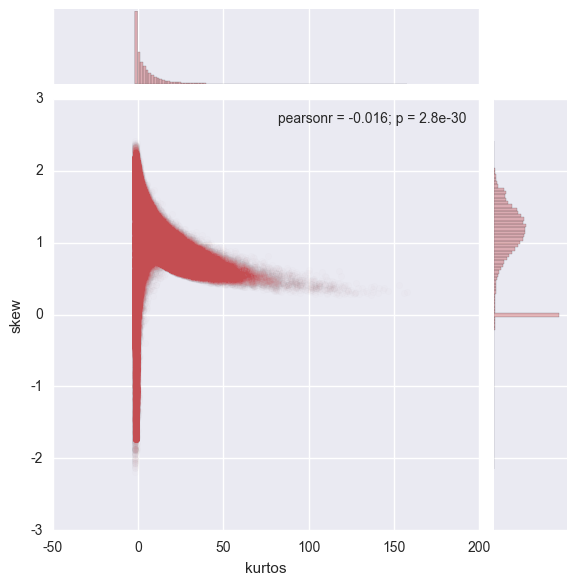

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', color_codes=True)
sns.jointplot('kurtos', 'skew', data=df, color='r', alpha=0.01, marginal_kws=dict(bins=100))

The distributions of importer-product pairs are mostly **mesokurtic** ($excess \ kurtosis \approx$ 0) and **not skewed** ($g_p \approx 0$). But we can see the distribution of skewness is actually bimodal: the other mode is a **positively skewed** ($g_p > 0$), **leptokurtic** ($excess \ kurtosis > 0$) distribution.  
  
Moreover, we observe that given a zero kurtosis, the distribution can be (1) not skewed (most likely); (2) positively skewed (second most likely); or (3) negatively skewed (most unlikely). In contrast, distributions with positive kurtosis are usually positively skewed, and the degree of skewness decreases as kurtosis increases. This suggests k = 5 may be a reasonable choice for the number of clusters.

In [5]:
from sklearn.preprocessing import Normalizer
from sklearn import cluster

scaler = Normalizer().fit(df)
normalized = scaler.transform(df)

n_clusters = 5

k_means = cluster.KMeans(n_clusters=n_clusters, n_init=20, random_state=3)
k_means.fit(normalized)
df['label'] = k_means.labels_

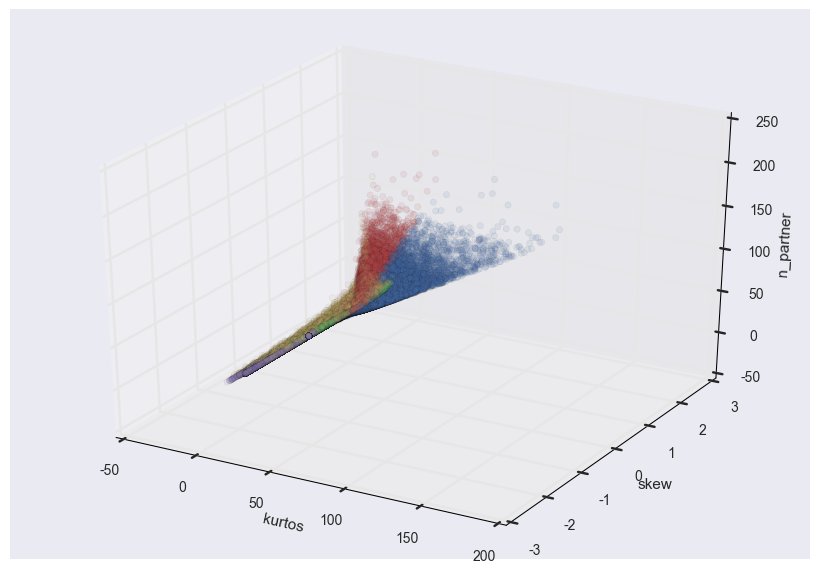

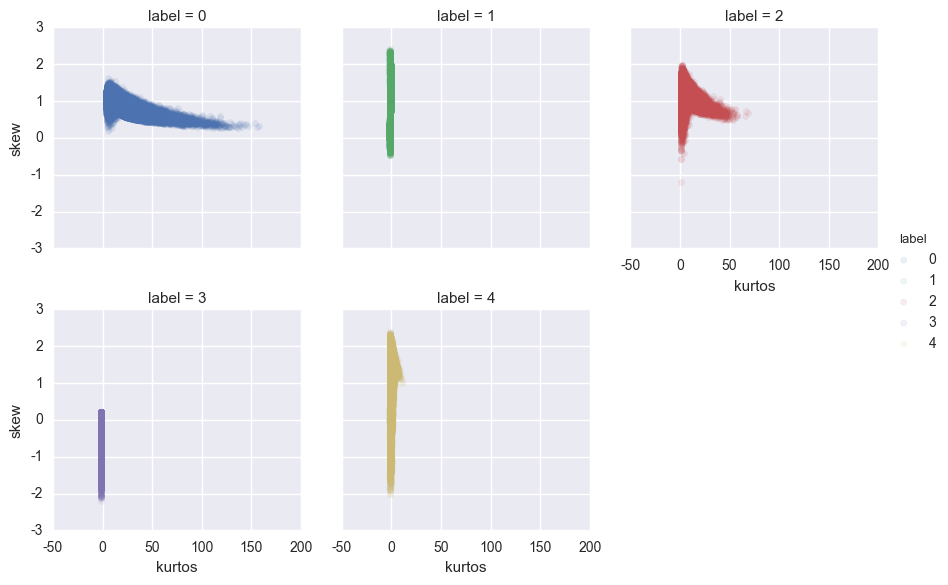

In [6]:
from matplotlib.colors import ListedColormap
import pylab
from mpl_toolkits.mplot3d import Axes3D

my_cmap = ListedColormap(sns.color_palette('deep', n_clusters).as_hex())

fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(df['kurtos'], df['skew'], df['n_partner'], c=df['label'], cmap=my_cmap, alpha=0.1)
ax.set_xlabel('kurtos')
ax.set_ylabel('skew')
ax.set_zlabel('n_partner')

g = sns.FacetGrid(df, col='label', col_wrap=3, hue='label')
g = (g.map(plt.scatter, 'kurtos', 'skew', alpha=0.1)
      .add_legend())

In [7]:
print(df.groupby('label').median())

       n_partner     kurtos      skew
label                                
0           21.0  12.357806  0.943766
1            4.0  -1.500000  1.365660
2           16.0   3.764584  1.226960
3            2.0  -2.000000  0.000000
4            8.0   0.126782  1.390219


Cluster Characteristics:
* Label 0: $kurtosis \gg 0$, slightly positively skewed, large ```n_partner``` (***red ocean***)
* Label 1: $kurtosis \approx 0$, positively skewed, small ```n_partner``` (***blue ocean***)
* Label 2: $kurtosis > 0$, positively skewed, large ```n_partner``` (***toward red ocean***)
* Label 3: $kurtosis \approx 0$, negatively skewed, small ```n_partner``` (***oligopoly***)
* Label 4: $kurtosis \approx 0$, median ```n_partner``` (***average***)